# Using ESN to build an e2e prediction system
Continuation of results from previous notebook `esn_lstm_multivariate.ipynb` with [blog post](https://ikespand.github.io/posts/ml-for-stock-market-1/)

## I. Obtaining data
Here, we get the data from Yahoo Finance API (yfinance package) which has some limitation for bulk and daily usage. So restricting the notebook to examination purpose.

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from easyesn import PredictionESN

Using Numpy backend.


Configurations

In [2]:
stock_name = "MSFT"
start_date="2021-01-01"
end_date="2025-03-28"
interval="1d"
n_steps = 7
train_test_split = 0.8

Create the instance for the given ticker

In [3]:
tikr = yf.Ticker(stock_name)
tikr_history = tikr.history(start=start_date, end=end_date, interval="1d")
#tikr_history = tikr.history(period="1mo", interval="5m")
#tikr_history = tikr.history(period="max")

We can run sentiment analysis if we want on the current news.

In [4]:
#print(tikr.news)
#print(tikr.info)

In [5]:
print("Shape of df", tikr_history.shape)
tikr_history.head(5)

Shape of df (1063, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,214.671080,215.124483,207.223720,210.002014,37130100,0.0,0.0
2021-01-05 00:00:00-05:00,209.587223,210.802734,208.082319,210.204620,23823000,0.0,0.0
2021-01-06 00:00:00-05:00,204.676974,208.844415,204.455101,204.754150,35930700,0.0,0.0
2021-01-07 00:00:00-05:00,206.480949,211.593777,206.162617,210.580856,27694500,0.0,0.0
2021-01-08 00:00:00-05:00,210.957056,212.789964,209.365333,211.863861,22956200,0.0,0.0


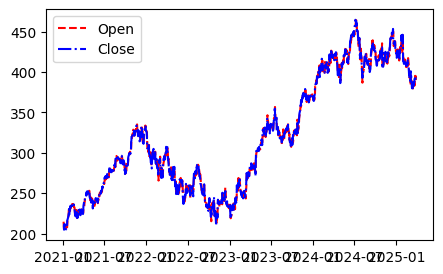

In [6]:
# Visualise the bid_price predictions
plt.figure(figsize = (5,3))
plt.plot(tikr_history['Open'], color = 'red', linestyle="--", label = 'Open')
plt.plot(tikr_history['Close'], color = 'blue', linestyle="-.", label = 'Close')
plt.legend()
plt.show()

#### Let's focus on limited columns
We will consider only 4 variables (Open, High, Low, Close), therefore dropping reamining columns.

In [7]:
tikr_history = tikr_history.drop(["Dividends", "Stock Splits", "Volume"], axis=1)
tikr_history.reset_index(inplace=True)
tikr_history.head(5)

,Date,Open,High,Low,Close
0,2021-01-04 00:00:00-05:00,214.671080,215.124483,207.223720,210.002014
1,2021-01-05 00:00:00-05:00,209.587223,210.802734,208.082319,210.204620
2,2021-01-06 00:00:00-05:00,204.676974,208.844415,204.455101,204.754150
3,2021-01-07 00:00:00-05:00,206.480949,211.593777,206.162617,210.580856
4,2021-01-08 00:00:00-05:00,210.957056,212.789964,209.365333,211.863861


## II. Building ESN model

## Data prepartion
- Separating the train and test data with an 80-20% split
- Scaling the data

In [8]:
#  Train-Test Split (as per train_test_split)
train_size = int(len(tikr_history) * train_test_split)
train_df = tikr_history.iloc[:train_size]
test_df = tikr_history.iloc[train_size:]

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[["Open", "High", "Low", "Close"]])
test_scaled = scaler.transform(test_df[["Open", "High", "Low", "Close"]])

# Prepare Data for Training
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps].flatten())  # Flatten past n_steps
        y.append(data[i + n_steps, -1].flatten())  # Next day's Close price
    return np.array(X), np.array(y)

x_train, y_train = create_sequences(train_scaled, n_steps)
x_test, y_test = create_sequences(test_scaled, n_steps)

print("X_train shape:", x_train.shape)  
print("y_train shape:", y_train.shape)  

X_train shape: (843, 28)
y_train shape: (843, 1)


Observe above, the shape of `x` and `y`. Let's double check: If, current x(t=0) has 3 values then its y(t=0) will be equal to the last element(s) in x(t=1) 

In [9]:
print(y_train[0][0]-x_train[n_steps][3])

0.0


In [32]:
%%time
esn = PredictionESN(
    n_input = x_train.shape[1],
    n_output = y_train.shape[1],
    n_reservoir= 50,
    spectralRadius=1,
    leakingRate=1,
    feedback=False,
    randomSeed = 42
)
esn.fit(x_train, y_train, transientTime="Auto", verbose=1)

  0% (0 of 784) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (0 of 784) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (784 of 784) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


CPU times: user 63.3 ms, sys: 7.32 ms, total: 70.6 ms
Wall time: 326 ms


0.020618554039543432

In [33]:
# Predict values from test data trained using training data and reverse transform
y_hat_scaled = esn.predict(x_test)
# Following part just to perform inverse transform as it expect n_features columns
y_hat_scaled_4 = np.repeat(y_hat_scaled, 4, axis=1)
y_hat = scaler.inverse_transform(y_hat_scaled_4)[:,0]
print("y_test.shape, y_hat.shape", y_test.shape, y_hat.shape)

y_test.shape, y_hat.shape (206, 1) (206,)


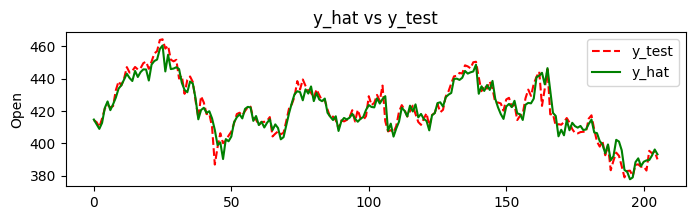

In [34]:
y_test_orig = test_df[n_steps:].reset_index(drop=True)
# Visualise the ask_price predictions
plt.figure(figsize = (8, 2))
plt.plot(y_test_orig['Open'], color = 'red', linestyle = "--", label = 'y_test')
plt.plot(y_hat, color = 'green', label = 'y_hat')
plt.title('y_hat vs y_test')
plt.ylabel('Open')
plt.legend()
plt.show()

Zoom-in to the last 100 values to see differences.

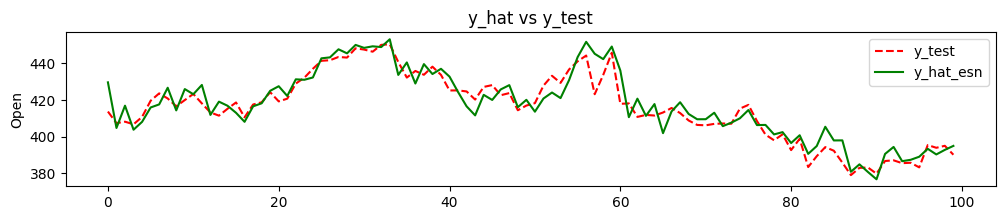

In [13]:
y_test_orig = test_df[n_steps:].reset_index(drop=True)
# Visualise the ask_price predictions
plt.figure(figsize = (12, 2))
plt.plot(y_test_orig['Open'][-100:].to_list(), color = 'red', linestyle = "--", label = 'y_test')
plt.plot(y_hat[-100:], color = 'green', label = 'y_hat_esn')
plt.title('y_hat vs y_test')
plt.ylabel('Open')
plt.legend()
plt.show()

Export the model for future use (ESN)

In [70]:
import dill as pickle
pickle.dump(esn, open(f"stock_esn_model_{n_steps}.pkl", "wb"))
# Can be use afterwards: esn = pickle.load(open("stock_esn_model.pkl", "rb"))

# Also save the scaler
pickle.dump(scaler, open(f"scaler_esn_model_{n_steps}.pkl", "wb"))

END OF NOTEBOOK